## История изменений

#### Базовый эксперимент

1. Что сделано.
  
  - Загружен датасет GSM8K

  - Проведено обучение qwen2.5-0.5B на датасете GSM8K-main на трех эпохах

2. Полученные результаты

  - Обученная модель с данными лоссов на обучающей выборке

3. Выводы

  - Предельное значение количества параметров - 500M, так как даже для обучения qwen2.5-0.5B на датасете 3 тысячах объектов GSM8K-main понадобилось 10 GB GPU и нельзя было использовать `batch_size > 3`.

  - Обучение больших моделей на сравнительно небольшом объеме данных занимает до часу времени. (личный вывод)


4. Чему научился

  - Пользоваться интерфейсом HuggingFace

  - Библиотека transformer, datasetы

  - Лучше изучил задачу text generation



## Библиотеки

В этой секции будут описаны базовые библиотеки, используемые практически для всех экспериментов.

In [ ]:
! pip install -q peft transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# basic libraries
import numpy as np
import pandas as pd
import torch
from torchsummary import summary

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

from datasets import load_dataset, Dataset

from peft import LoraConfig, PeftModel, get_peft_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

ModuleNotFoundError: No module named 'datasets'

-----------------
## Датасеты

На данный момент используются датасеты:

- gsm8k: main и socratic

In [ ]:
datasets = {}

In [ ]:
datasets['gsm_main'] = load_dataset("openai/gsm8k", "main")
datasets['gsm_socratic'] = load_dataset("openai/gsm8k", "socratic")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/487k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

--------------

## Обучение моделей
---------------

### Text generation

#### Qwen 2.5-0.5B only LoRA

Обучим модель Qwen2.5-0.5B, используя только адаптеры LoRA для получения бейзлайна

In [ ]:
# Подгружаем токенайзер и модель
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B").to(device)

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [ ]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

Теперь поработаем с данными, а именно нужно токенизировать и провести padding

In [ ]:
datasets['gsm_main']['train']

Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

In [ ]:
next(iter(datasets['gsm_main']['train']))

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}

In [ ]:
max_length = 0
for text in datasets['gsm_main']['train']['question']:
    max_length = max(max_length, len(text))
tokenizer.model_max_length = max_length

Так как Qwen2.5-0.5B использует примерно 2.1 Gb памяти и оставшейся памяти не хватает для обучения, то сократим размер датасета вдвое.

In [ ]:
# Преобразование данных
def format_row_qwen_gsm(elem, tokenizer):
    messages = [{"role": "user", "content": elem['question']}]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True
    ).to(device)

    answer_ids = tokenizer(
        elem['answer'],
        return_tensors="pt",
        padding="max_length",
        truncation=True
    )['input_ids'].to(device)
    inputs['labels'] = answer_ids[0]
    inputs['input_ids'] = inputs['input_ids'][0]
    inputs['attention_mask'] = inputs['attention_mask'][0]

    return inputs

def format_dataset_qwen_gsm(dataset, tokenizer):
    return dataset.map(lambda elem: format_row_qwen_gsm(elem, tokenizer))


# Ограничение датасетов
train_size = 3000
test_size = 1000
train_dataset = Dataset.from_dict(datasets['gsm_main']['train'][:train_size])
val_dataset = Dataset.from_dict(datasets['gsm_main']['test'][:train_size])

# Токенизация
train_dataset = format_dataset_qwen_gsm(train_dataset, tokenizer)
val_dataset = format_dataset_qwen_gsm(val_dataset, tokenizer)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
train_dataset = train_dataset.remove_columns(['question', 'answer'])
val_dataset = val_dataset.remove_columns(['question', 'answer'])

In [ ]:
# настройка параметров Лоры
lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "k_proj", "v_proj"]
    )

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 737,280 || all params: 494,770,048 || trainable%: 0.1490


In [ ]:
account = "MuQianyu"
peft_model_id = f"{account}/qwen2.5-0.5B_only_lora"
batch_size = 2

args = TrainingArguments(
    peft_model_id,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    logging_steps=10,
    label_names=["answer_ids"],
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)
trainer.train()

<ipython-input-15-b3f53e6d1164>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mu_qianyu (mu_qianyu-mipt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.769000,No log
2,0.906200,No log


TrainOutput(global_step=3000, training_loss=1.1117058957417807, metrics={'train_runtime': 5989.6674, 'train_samples_per_second': 1.002, 'train_steps_per_second': 0.501, 'total_flos': 1.271721100032e+16, 'train_loss': 1.1117058957417807, 'epoch': 2.0})

Попробуем обучить еще на одной эпохе

In [ ]:
args = TrainingArguments(
    peft_model_id,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    logging_steps=10,
    label_names=["answer_ids"],
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)
trainer.train()

<ipython-input-16-da16a88a45a4>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.737700,No log


TrainOutput(global_step=1500, training_loss=0.7162192662556967, metrics={'train_runtime': 2965.7117, 'train_samples_per_second': 1.012, 'train_steps_per_second': 0.506, 'total_flos': 6358605500160000.0, 'train_loss': 0.7162192662556967, 'epoch': 1.0})

In [ ]:
model.save_pretrained('qwen2.5-5b__gsm__only_lora', from_pt=True)

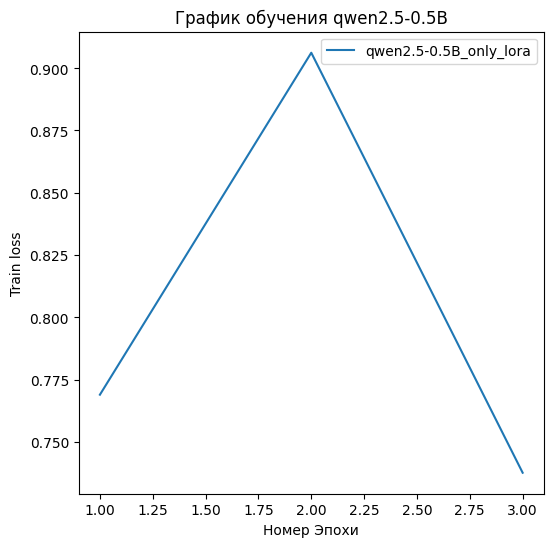

In [ ]:
import matplotlib.pyplot as plt
results = [0.769000, 0.906200, 0.737700]

plt.figure(figsize=(6, 6))
plt.title('График обучения qwen2.5-0.5B')
plt.xlabel('Номер Эпохи')
plt.ylabel('Train loss')
plt.plot(np.arange(1, 4), results, label='qwen2.5-0.5B_only_lora')

plt.legend()
plt.show()

In [48]:
def color_map_color(value, cmap_name='YlOrRd', vmin=8, vmax=15):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

<ipython-input-48-b1fd6ab1578b>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)  # PiYG


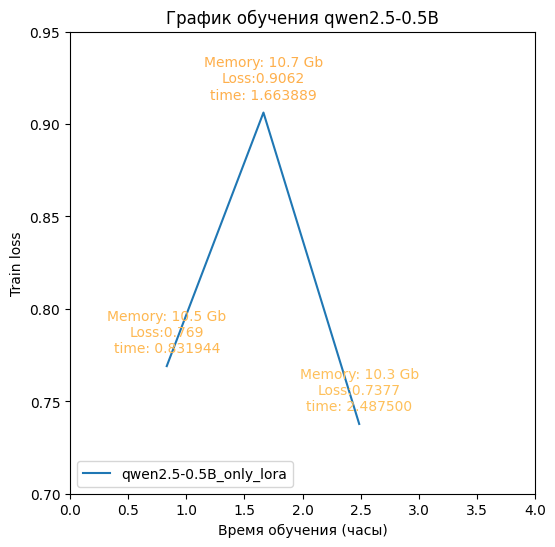

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
results = [0.769000, 0.906200, 0.737700]
train_time = np.array([2995, 5990, 8955]) / 3600
memory_usage = [10.5, 10.7, 10.3]

plt.figure(figsize=(6, 6))
plt.title('График обучения qwen2.5-0.5B')
plt.xlabel('Время обучения (часы)')
plt.ylabel('Train loss')
plt.ylim([0.7, 0.95])
plt.xlim([0, 4])
plt.plot(train_time, results, label='qwen2.5-0.5B_only_lora')

for result, time, memory in zip(results, train_time, memory_usage):
    plt.annotate(
        f'Memory: {memory} Gb\nLoss:{result}\ntime: {time:2f}',
        (time, result),
        textcoords="offset points",
        xytext=(0,10),
        ha='center',
        fontsize=10,
        color=color_map_color(memory)
    )


plt.legend()
plt.show()